<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/RECONOCIMIENTO-DE-FORMAS-Y-APRENDIZAJE-COMPUTACIONAL/blob/main/SEMANA%2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEMANA 15
## TEMA 5. MATERIALES Y TEXTURA.

5.7. Datasets y problemas específicos.

5.8. Técnicas de fusión de datos.

5.9. Aplicaciones prácticas.

5.10. Desafíos futuros.

Objetivo: Conocer los datasets clave y los retos del área, explorar fusión de datos (RGB, normales, profundidad, BRDF) y proyectar aplicaciones y tendencias.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================
# 2. PIPELINE DE DATOS
#   - first_image_path: enlaza PetID -> primera imagen
#   - preprocess_for_backbone: normaliza imagen para MobileNetV2
#   - load_*: funciones que cargan ejemplo(s) individuales
#   - make_*_ds: construyen tf.data.Dataset para:
#       * solo imagen
#       * solo tabular
#       * multimodal (imagen + tabular)
#
# Idea didáctica:
#   - Separar claramente "cargar un ejemplo" de "construir el dataset".
#   - Mostrar cómo la misma tabla (DataFrame) se transforma en
#     tres vistas diferentes: imagen / tabla / multimodal.
# ============================================


# 2.2 Crear ruta a la primera imagen por PetID
def first_image_path(pet_id: str) -> str:
    """
    Dado un PetID (por ejemplo '8a3bb1f7f'), busca en la carpeta TRAIN_IMG_DIR
    todos los archivos que coincidan con el patrón:
        {PetID}-*.jpg
    y devuelve la primera ruta encontrada.

    Si no encuentra ninguna imagen, devuelve None.
    Esto se usa para construir la columna 'img_path' en el DataFrame.
    """
    # glob busca archivos cuyo nombre coincide con un patrón con comodines
    pattern = list((TRAIN_IMG_DIR).glob(f"{pet_id}-*.jpg"))
    if len(pattern) == 0:
        return None
    # Tomamos la primera en orden (si hay varias fotos del mismo PetID)
    return str(pattern[0])


# -------------------------------------------------
# Preprocesamiento específico del backbone
# -------------------------------------------------
def preprocess_for_backbone(x):
    """
    Aplica el preprocesamiento recomendado por MobileNetV2.

    - La imagen viene en [0,1] tipo float32.
    - preprocess_input la reescala a aproximadamente [-1,1].
    - Esto hace que la distribución de píxeles sea consistente
      con la que vio el modelo al entrenarse en ImageNet.
    """
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    return preprocess_input(x)


# -------------------------------------------------
# Funciones load_*: reciben TENSORES (no DataFrames)
# y devuelven (entrada, etiqueta) listos para el modelo.
# Estas funciones se usan dentro de tf.data.Dataset.map().
# -------------------------------------------------

def load_image_only(path, y):
    """
    Carga un ejemplo SOLO IMAGEN desde disco y codifica la etiqueta.

    Parámetros
    ----------
    path : tf.Tensor (string)
        Ruta al archivo .jpg en disco.
    y : tf.Tensor (int)
        Id de clase (entero), p.ej. 0,1,2,3,4.

    Devuelve
    --------
    img : tf.Tensor (IMG_SIZE, IMG_SIZE, 3)
        Imagen preprocesada para MobileNetV2.
    y_onehot : tf.Tensor (N_CLASSES,)
        Etiqueta en one-hot.
    """
    # Lee el archivo en bruto
    raw = tf.io.read_file(path)
    # Decodifica JPEG → tensor 3 canales
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    # Redimensiona a tamaño fijo
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # Convierte a float32 en [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Aplica preprocesamiento del backbone (MobileNetV2)
    img = preprocess_for_backbone(img)

    # Convierte y (id de clase) a one-hot
    y   = tf.one_hot(y, depth=len(CLASSES))
    return img, y


def load_tab_only(tab_vals, y):
    """
    Carga un ejemplo SOLO TABULAR (ya viene desde el DataFrame)
    y codifica la etiqueta.

    Parámetros
    ----------
    tab_vals : tf.Tensor (N_TAB,)
        Vector de atributos tabulares (numéricos + one-hot).
    y : tf.Tensor (int)
        Id de clase.

    Devuelve
    --------
    tab : tf.Tensor (N_TAB,)
        Atributos en float32.
    y_onehot : tf.Tensor (N_CLASSES,)
        Etiqueta en one-hot.
    """
    tab = tf.cast(tab_vals, tf.float32)
    y   = tf.one_hot(y, depth=len(CLASSES))
    return tab, y


def load_multimodal(path, tab_vals, y):
    """
    Carga un ejemplo MULTIMODAL: (imagen + tabular).

    Devuelve ((img, tab), y_onehot) para que se pueda conectar
    directamente a un modelo con dos entradas:
        [img_in, tab_in]
    """
    # --- Imagen (igual que en load_image_only) ---
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = preprocess_for_backbone(img)

    # --- Vector tabular ---
    tab = tf.cast(tab_vals, tf.float32)

    # --- Etiqueta en one-hot ---
    y   = tf.one_hot(y, depth=len(CLASSES))

    # Devolvemos una tupla anidada:
    #   entradas: (img, tab)
    #   salida:   y
    return (img, tab), y


# -------------------------------------------------
# make_*_ds: a partir de un DataFrame de pandas
# construyen un tf.data.Dataset para entrenamiento
# -------------------------------------------------

def make_image_ds(frame, shuffle=True, repeat=False):
    """
    Construye un tf.data.Dataset SOLO IMAGEN a partir de un DataFrame.

    El DataFrame 'frame' debe contener:
      - columna 'img_path': rutas a archivos .jpg
      - columna 'y_id': id de clase (entero)

    El pipeline:
      1) from_tensor_slices: crea dataset de (path, y).
      2) map(load_image_only): carga y preprocesa las imágenes.
      3) shuffle (opcional): mezcla ejemplos.
      4) repeat (opcional): repite indefinidamente (útil para .fit con steps_per_epoch).
      5) batch: agrupa en mini-batches.
      6) prefetch: optimiza el pipeline (overlap CPU/GPU).
    """
    paths = frame["img_path"].values
    ys    = frame["y_id"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, ys))
    ds = ds.map(load_image_only, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


def make_tab_ds(frame, shuffle=True, repeat=False):
    """
    Construye un tf.data.Dataset SOLO TABULAR.

    El DataFrame 'frame' debe contener:
      - columnas TAB_COLS: atributos numéricos + one-hot
      - columna 'y_id': id de clase

    Cada ejemplo del dataset será (tab_vector, y_onehot).
    """
    tabs = frame[TAB_COLS].values.astype("float32")  # (N_samples, N_TAB)
    ys   = frame["y_id"].values

    ds = tf.data.Dataset.from_tensor_slices((tabs, ys))
    ds = ds.map(load_tab_only, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


def make_multimodal_ds(frame, shuffle=True, repeat=False):
    """
    Construye un tf.data.Dataset MULTIMODAL (imagen + tabular).

    El DataFrame 'frame' debe contener:
      - 'img_path': ruta a imagen
      - TAB_COLS: columnas de atributos
      - 'y_id': id de clase

    Cada ejemplo del dataset será:
      ((img, tab), y_onehot)
    que coincide con los modelos con dos entradas:
      model([img_in, tab_in]) → predicción.
    """
    paths = frame["img_path"].values                    # rutas a imágenes
    tabs  = frame[TAB_COLS].values.astype("float32")    # matriz tabular
    ys    = frame["y_id"].values                        # ids de clase

    ds = tf.data.Dataset.from_tensor_slices((paths, tabs, ys))
    ds = ds.map(load_multimodal, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [ ]:
# ============================================
# 8. EVALUACIÓN Y COMPARACIÓN
# ============================================

def predict_ds_image(model, ds):
    y_true, y_pred = [], []
    for xb, yb in ds:
        p = model.predict(xb, verbose=0)
        y_pred.append(p)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

def predict_ds_tab(model, ds):
    y_true, y_pred = [], []
    for xb, yb in ds:
        p = model.predict(xb, verbose=0)
        y_pred.append(p)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

def predict_ds_mm(model, ds):
    y_true, y_pred = [], []
    for (xi, xt), yb in ds:
        p = model.predict([xi, xt], verbose=0)
        y_pred.append(p)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

def eval_probs(y_true_onehot, y_pred_probs, name="modelo"):
    y_true = np.argmax(y_true_onehot, axis=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f}")
    print(classification_report(y_true, y_pred, target_names=[str(c) for c in CLASSES]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicción"); plt.ylabel("Real"); plt.title(name)
    plt.show()
    return acc, f1m

In [ ]:

# TODO: ajusta la ruta a donde tengas PetFinder.zip en tu Drive
ZIP_PATH = "/content/drive/MyDrive/A105 RECONOCIMIENTO DE FORMAS Y APRENDIZAJE COMPUTACIONAL /Clases/Semana 15/PetFinder.zip"

!unzip -q "{ZIP_PATH}" -d "/content/PetFinder"


In [ ]:
import os, numpy as np, pandas as pd
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR   = Path("/content/PetFinder")  # carpeta creada al descomprimir
TRAIN_CSV  = BASE_DIR / "train" / "train.csv"
TRAIN_IMG_DIR = BASE_DIR / "train_images"

IMG_SIZE   = 160
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE


In [ ]:
import time
import pandas as pd
from tqdm import tqdm

tqdm.pandas()  # <- necesario para progress_apply

t0 = time.time()

# 2.1 Cargar train.csv
df = pd.read_csv(TRAIN_CSV)

print("🔄 Enlazando PetID -> primera imagen (esto puede tardar un poco)...")

# Barra de progreso mientras se construye img_path
df["img_path"] = df["PetID"].progress_apply(first_image_path)

# Quitar filas sin imagen
df = df.dropna(subset=["img_path"]).reset_index(drop=True)

# 2.3 Definir etiqueta
df["y"] = df["AdoptionSpeed"]
CLASSES = sorted(df["y"].unique().tolist())
class_to_id = {c: i for i, c in enumerate(CLASSES)}
df["y_id"] = df["y"].map(class_to_id)

t1 = time.time()

print("Clases:", CLASSES, "->", class_to_id)
print(f"Registros con imagen válida: {len(df)}")
print(f"⏱ Tiempo total: {t1 - t0:.2f} s")

df[["PetID","img_path","y","y_id"]].head()


🔄 Enlazando PetID -> primera imagen (esto puede tardar un poco)...


100%|██████████| 14993/14993 [14:55<00:00, 16.74it/s]

Clases: [0, 1, 2, 3, 4] -> {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Registros con imagen válida: 14652
⏱ Tiempo total: 896.08 s


,PetID,img_path,y,y_id
0,86e1089a3,/content/PetFinder/train_images/86e1089a3-1.jpg,2,2
1,6296e909a,/content/PetFinder/train_images/6296e909a-2.jpg,0,0
2,3422e4906,/content/PetFinder/train_images/3422e4906-1.jpg,3,3
3,5842f1ff5,/content/PetFinder/train_images/5842f1ff5-4.jpg,2,2
4,850a43f90,/content/PetFinder/train_images/850a43f90-3.jpg,2,2


In [ ]:
# Columnas numéricas y categóricas para la parte tabular
num_cols = ["Age", "Quantity", "Fee", "PhotoAmt"]
cat_cols = ["Type", "Gender", "MaturitySize", "FurLength",
            "Vaccinated", "Dewormed", "Sterilized", "Health"]

# 3.1 Manejo de faltantes
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(-1)  # valor especial para 'desconocido'

# 3.2 One-hot de categóricas
df_cat = pd.get_dummies(df[cat_cols].astype(int).astype(str), prefix=cat_cols)

# 3.3 Escalado de numéricas
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols].values)
df_num = pd.DataFrame(X_num, columns=[f"num_{c}" for c in num_cols])

# 3.4 Matriz tabular final
df_tab = pd.concat([df_num, df_cat], axis=1)
TAB_COLS = list(df_tab.columns)

# 3.5 DataFrame maestro (ruta, features tabulares, label)
df_full = pd.concat(
    [df[["img_path","y_id"]].reset_index(drop=True), df_tab.reset_index(drop=True)],
    axis=1
)

df_full.head()


,img_path,y_id,num_Age,num_Quantity,num_Fee,num_PhotoAmt,Type_1,Type_2,Gender_1,Gender_2,...,Vaccinated_3,Dewormed_1,Dewormed_2,Dewormed_3,Sterilized_1,Sterilized_2,Sterilized_3,Health_1,Health_2,Health_3
0,/content/PetFinder/train_images/86e1089a3-1.jpg,2,-0.407810,-0.390131,1.002512,-0.857077,False,True,True,False,...,False,False,True,False,False,True,False,True,False,False
1,/content/PetFinder/train_images/6296e909a-2.jpg,0,-0.518591,-0.390131,-0.271049,-0.569441,False,True,True,False,...,True,False,False,True,False,False,True,True,False,False
2,/content/PetFinder/train_images/3422e4906-1.jpg,3,-0.518591,-0.390131,-0.271049,0.868738,True,False,True,False,...,False,True,False,False,False,True,False,True,False,False
3,/content/PetFinder/train_images/5842f1ff5-4.jpg,2,-0.352420,-0.390131,1.639293,1.156373,True,False,False,True,...,False,True,False,False,False,True,False,True,False,False
4,/content/PetFinder/train_images/850a43f90-3.jpg,2,-0.518591,-0.390131,-0.271049,-0.281805,True,False,True,False,...,False,False,True,False,False,True,False,True,False,False


In [ ]:
train_df, test_df = train_test_split(
    df_full, test_size=0.2, stratify=df_full["y_id"], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["y_id"], random_state=42
)

len(train_df), len(val_df), len(test_df)


(9376, 2345, 2931)

In [ ]:
train_img_ds = make_image_ds(train_df, shuffle=True,  repeat=True)
val_img_ds   = make_image_ds(val_df,   shuffle=False)
test_img_ds  = make_image_ds(test_df,  shuffle=False)

train_tab_ds = make_tab_ds(train_df, shuffle=True,  repeat=True)
val_tab_ds   = make_tab_ds(val_df,   shuffle=False)
test_tab_ds  = make_tab_ds(test_df,  shuffle=False)

train_mm_ds  = make_multimodal_ds(train_df, shuffle=True,  repeat=True)
val_mm_ds    = make_multimodal_ds(val_df,   shuffle=False)
test_mm_ds   = make_multimodal_ds(test_df,  shuffle=False)


In [ ]:
# ============================================
# 6. MODELOS MULTIMODALES (IMAGEN + TABULAR)
# ============================================
# En esta sección definimos cuatro modelos:
#
# 1) build_early_fusion_model()
#    - Fusión TEMPRANA: aplanamos la imagen y la pegamos al vector tabular.
#    - El "extractor" denso aprende directamente de la mezcla cruda.
#
# 2) build_intermediate_fusion_model()
#    - Fusión INTERMEDIA: cada modalidad aprende su embedding
#      (CNN para imagen, MLP para tablas) y luego concatenamos
#      estos embeddings en una capa oculta.
#
# 3) build_image_only_model()
#    - Modelo de referencia (baseline) SOLO IMAGEN.
#
# 4) build_tab_only_model()
#    - Modelo de referencia SOLO TABULAR.
#
# A partir de estos cuatro modelos podremos comparar:
#   - ¿Cuánto aporta la imagen sola?
#   - ¿Cuánto aportan los datos tabulares solos?
#   - ¿Qué tanto mejora (si mejora) al combinarlos temprano / intermedio / tarde?
# ============================================

N_CLASSES = len(CLASSES)   # número de clases (AdoptionSpeed o la versión que hayas definido)
N_TAB     = len(TAB_COLS)  # longitud del vector tabular (columnas num+one-hot)


# ----------------------------------------------------------
# 6.1 EARLY FUSION (FUSIÓN TEMPRANA)
# ----------------------------------------------------------
# IDEA:
#   - Tomar la imagen ya preprocesada como un gran vector 1D (Flatten).
#   - Normalizar y comprimir el vector tabular.
#   - Concatenar ambos vectores en una sola representación "temprana".
#   - Pasar ese vector por capas densas para que el modelo aprenda
#     directamente relaciones imagen+tablas desde el inicio.
def build_early_fusion_model():
    # Entrada de imagen: tensor 4D (H, W, C)
    img_in = keras.Input((IMG_SIZE, IMG_SIZE, 3), name="img")

    # Entrada tabular: vector 1D con N_TAB atributos
    tab_in = keras.Input((N_TAB,), name="tab")

    # ----- RAMA IMAGEN -----
    # Aquí NO usamos todavía una CNN preentrenada: aplanamos la imagen cruda.
    # Los alumnos pueden ver esto como “tirar la imagen en un vector largo”.
    x = layers.Flatten(name="img_flatten")(img_in)

    # ----- RAMA TABULAR -----
    # BatchNormalization ayuda a estabilizar el entrenamiento
    # (cada batch tiene media ~0 y varianza ~1).
    t = layers.BatchNormalization(name="tab_bn")(tab_in)
    # Pequeño MLP para que la red aprenda una representación compacta del tabular.
    t = layers.Dense(64, activation="relu", name="tab_dense1")(t)

    # ----- FUSIÓN TEMPRANA -----
    # Concatenamos el vector de imagen (x) y el vector tabular (t).
    z = layers.Concatenate(name="early_concat")([x, t])

    # Capas densas que operan ya sobre la mezcla imagen+tablas.
    z = layers.Dense(256, activation="relu", name="early_dense1")(z)
    z = layers.Dropout(0.3, name="early_drop1")(z)
    z = layers.Dense(128, activation="relu", name="early_dense2")(z)
    z = layers.Dropout(0.3, name="early_drop2")(z)

    # Capa de salida con softmax para clasificación multiclase.
    out = layers.Dense(N_CLASSES, activation="softmax", name="cls")(z)

    # Definimos el modelo indicando qué entra ([img_in, tab_in]) y qué sale (out).
    model = keras.Model([img_in, tab_in], out, name="early_fusion")

    # Compilamos con Adam y entropía cruzada categórica (one-hot en la salida).
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# ----------------------------------------------------------
# 6.2 INTERMEDIATE FUSION (FUSIÓN INTERMEDIA)
# ----------------------------------------------------------
# IDEA:
#   - Cada modalidad tiene su propio “cerebro”:
#       * CNN preentrenada (MobileNetV2) para la imagen.
#       * MLP para los datos tabulares.
#   - Primero dejamos que cada rama aprenda su embedding.
#   - Después concatenamos esos embeddings en un punto intermedio
#     y añadimos capas densas para aprender las interacciones conjuntas.
def build_intermediate_fusion_model():
    img_in = keras.Input((IMG_SIZE, IMG_SIZE, 3), name="img")
    tab_in = keras.Input((N_TAB,), name="tab")

    # ----- RAMA IMAGEN (BACKBONE PREENTRENADO) -----
    # Usamos MobileNetV2 sin la “cabeza” final (include_top=False).
    # input_tensor=img_in indica que toma nuestra imagen como entrada.
    base = keras.applications.MobileNetV2(
        include_top=False,
        input_tensor=img_in,
        weights="imagenet",
    )

    # Congelamos todas las capas del backbone al inicio:
    # no se actualizan sus pesos durante la primera fase de entrenamiento.
    for l in base.layers:
        l.trainable = False

    # Convertimos el mapa de características final en un vector (GlobalAveragePooling2D)
    x = layers.GlobalAveragePooling2D(name="img_gap")(base.output)
    # Dropout para regularización (evitar sobreajuste)
    x = layers.Dropout(0.3, name="img_drop")(x)   # embedding de imagen

    # ----- RAMA TABULAR -----
    t = layers.BatchNormalization(name="tab_bn")(tab_in)
    t = layers.Dense(64, activation="relu", name="tab_dense1")(t)
    t = layers.Dropout(0.2, name="tab_drop1")(t)
    t = layers.Dense(32, activation="relu", name="tab_dense2")(t)

    # ----- FUSIÓN INTERMEDIA -----
    # Aquí cada rama ya aprendió su representación: x (imagen), t (tabular).
    # Fusionamos esos embeddings.
    z = layers.Concatenate(name="intermediate_concat")([x, t])

    # Capas densas finales que integran la información multimodal.
    z = layers.Dense(64, activation="relu", name="inter_dense1")(z)
    z = layers.Dropout(0.3, name="inter_drop1")(z)

    out = layers.Dense(N_CLASSES, activation="softmax", name="cls")(z)

    model = keras.Model([img_in, tab_in], out, name="intermediate_fusion")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# ----------------------------------------------------------
# 6.3 LATE FUSION – MODELOS BASE
# ----------------------------------------------------------
# En la fusión tardía NO construimos un solo modelo multimodal,
# sino dos modelos independientes:
#   - Uno que solo ve la imagen.
#   - Otro que solo ve la tabla.
# Luego, en la etapa de evaluación, combinamos sus probabilidades
# (por ejemplo, promedio 0.5 imagen + 0.5 tabular).
#
# Estos modelos también sirven como baselines para comparar contra
# Early e Intermediate fusion.


def build_image_only_model():
    """
    Modelo baseline SOLO IMAGEN:
    - MobileNetV2 preentrenada en ImageNet (feature extractor).
    - Pooling + Dropout + capa densa final.
    """
    img_in = keras.Input((IMG_SIZE, IMG_SIZE, 3), name="img")

    base = keras.applications.MobileNetV2(
        include_top=False,
        input_tensor=img_in,
        weights="imagenet",
    )

    # Al inicio congelamos el backbone (se puede descongelar después para fine-tuning).
    for l in base.layers:
        l.trainable = False

    x = layers.GlobalAveragePooling2D(name="img_gap")(base.output)
    x = layers.Dropout(0.3, name="img_drop")(x)
    out = layers.Dense(N_CLASSES, activation="softmax", name="cls")(x)

    model = keras.Model(img_in, out, name="image_only")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_tab_only_model():
    """
    Modelo baseline SOLO TABULAR:
    - Normaliza el vector de atributos.
    - Aplica un pequeño MLP (2 capas densas) y una capa softmax final.
    """
    tab_in = keras.Input((N_TAB,), name="tab")

    x = layers.BatchNormalization(name="tab_bn")(tab_in)
    x = layers.Dense(64, activation="relu", name="tab_dense1")(x)
    x = layers.Dropout(0.2, name="tab_drop1")(x)
    x = layers.Dense(32, activation="relu", name="tab_dense2")(x)
    x = layers.Dropout(0.2, name="tab_drop2")(x)
    out = layers.Dense(N_CLASSES, activation="softmax", name="cls")(x)

    model = keras.Model(tab_in, out, name="tab_only")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
# ============================================
# 7. ENTRENAMIENTO DE MODELOS
# ============================================

EPOCHS = 40
STEPS_PER_EPOCH = 50   # ajusta según tamaño de train

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    )
]

histories = {}

print("\n=== Entrenando modelo SOLO IMAGEN (late fusion - componente) ===")
img_model = build_image_only_model()
hist_img = img_model.fit(
    train_img_ds,
    validation_data=val_img_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks,
    verbose=1,
)
histories["image_only"] = hist_img

print("\n=== Entrenando modelo SOLO TABULAR (late fusion - componente) ===")
tab_model = build_tab_only_model()
hist_tab = tab_model.fit(
    train_tab_ds,
    validation_data=val_tab_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks,
    verbose=1,
)
histories["tab_only"] = hist_tab


=== Entrenando modelo SOLO IMAGEN (late fusion - componente) ===


/tmp/ipython-input-3754263765.py:166: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.2466 - loss: 2.4003 - val_accuracy: 0.2806 - val_loss: 1.7584
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2396 - loss: 2.0455 - val_accuracy: 0.2772 - val_loss: 1.6883
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2739 - loss: 1.9264 - val_accuracy: 0.2878 - val_loss: 1.6725
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2688 - loss: 1.9656 - val_accuracy: 0.2934 - val_loss: 1.6238
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2936 - loss: 1.8180 - val_accuracy: 0.2942 - val_loss: 1.6448
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2944 - loss: 1.8080 - val_accuracy: 0.2887 - val_loss: 1.5701
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3126 - loss: 1.6544 - val_accuracy: 0.2972 - val_loss: 1.5724
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3287 - loss: 1.6522 - val_accuracy: 0.2942 - val

In [ ]:
print("\n=== Entrenando modelo EARLY FUSION (imagen + tablas) ===")
early_model = build_early_fusion_model()
hist_early = early_model.fit(
    train_mm_ds,
    validation_data=val_mm_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks,
    verbose=1,
)
histories["early_fusion"] = hist_early

print("\n=== Entrenando modelo INTERMEDIATE FUSION (imagen + tablas) ===")
inter_model = build_intermediate_fusion_model()
hist_inter = inter_model.fit(
    train_mm_ds,
    validation_data=val_mm_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks,
    verbose=1,
)
histories["intermediate_fusion"] = hist_inter


=== Entrenando modelo EARLY FUSION (imagen + tablas) ===
Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 577ms/step - accuracy: 0.2051 - loss: 19.1037 - val_accuracy: 0.2559 - val_loss: 8.7168
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - accuracy: 0.2433 - loss: 12.9182 - val_accuracy: 0.2371 - val_loss: 2.6664
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 557ms/step - accuracy: 0.2463 - loss: 4.6683 - val_accuracy: 0.2623 - val_loss: 1.6466
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 572ms/step - accuracy: 0.2700 - loss: 2.4098 - val_accuracy: 0.2742 - val_loss: 1.5909
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.2449 - loss: 2.0115 - val_accuracy: 0.2712 - val_loss: 1.5648
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 637ms/step - accuracy: 0.2715 - loss: 1.7798 - val_accuracy: 0.2759 - val_loss: 1.5542
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.2911 - loss: 1.7431 - val_accuracy: 0.2733 - val_loss: 1.5441
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━

/tmp/ipython-input-3754263765.py:101: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.2178 - loss: 2.1080 - val_accuracy: 0.2751 - val_loss: 1.4861
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2789 - loss: 1.5438 - val_accuracy: 0.2968 - val_loss: 1.4551
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2779 - loss: 1.4856 - val_accuracy: 0.2947 - val_loss: 1.4517
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2818 - loss: 1.4687 - val_accuracy: 0.2972 - val_loss: 1.4474
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2939 - loss: 1.4960 - val_accuracy: 0.3173 - val_loss: 1.4433
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2988 - loss: 1.4606 - val_accuracy: 0.3271 - val_loss: 1.4352
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3295 - loss: 1.4293 - val_accuracy: 0.3288 - val_loss: 1.4344
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.3345 - loss: 1.4534 - val_accuracy: 0.3403 - val_l


=== Solo imagen ===
Accuracy: 0.3081 | F1-macro: 0.2043
              precision    recall  f1-score   support

           0       0.08      0.01      0.02        77
           1       0.26      0.16      0.20       611
           2       0.29      0.45      0.35       801
           3       0.24      0.01      0.02       645
           4       0.35      0.54      0.43       797

    accuracy                           0.31      2931
   macro avg       0.24      0.24      0.20      2931
weighted avg       0.28      0.31      0.26      2931



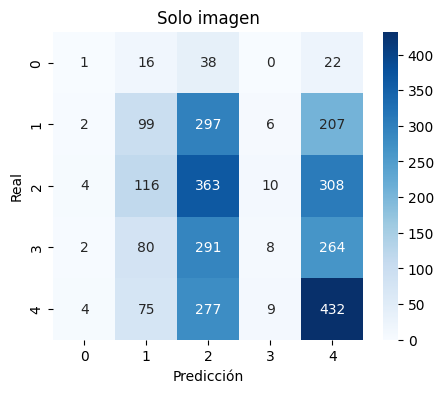


=== Solo tabular ===
Accuracy: 0.3443 | F1-macro: 0.2594
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.31      0.24      0.27       611
           2       0.32      0.49      0.38       801
           3       0.34      0.15      0.21       645
           4       0.40      0.47      0.43       797

    accuracy                           0.34      2931
   macro avg       0.27      0.27      0.26      2931
weighted avg       0.34      0.34      0.32      2931



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


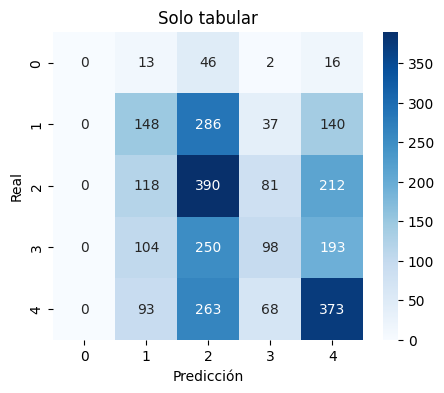


=== Early Fusion (imagen+tablas) ===
Accuracy: 0.2712 | F1-macro: 0.0981
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.16      0.01      0.03       611
           2       0.27      0.96      0.43       801
           3       0.19      0.01      0.01       645
           4       0.26      0.01      0.02       797

    accuracy                           0.27      2931
   macro avg       0.18      0.20      0.10      2931
weighted avg       0.22      0.27      0.13      2931



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


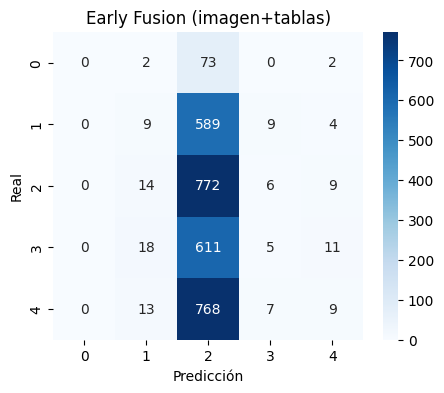


=== Intermediate Fusion (imagen+tablas) ===
Accuracy: 0.3132 | F1-macro: 0.1733
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.25      0.02      0.03       611
           2       0.30      0.48      0.37       801
           3       0.21      0.02      0.03       645
           4       0.33      0.65      0.44       797

    accuracy                           0.31      2931
   macro avg       0.22      0.23      0.17      2931
weighted avg       0.27      0.31      0.23      2931



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


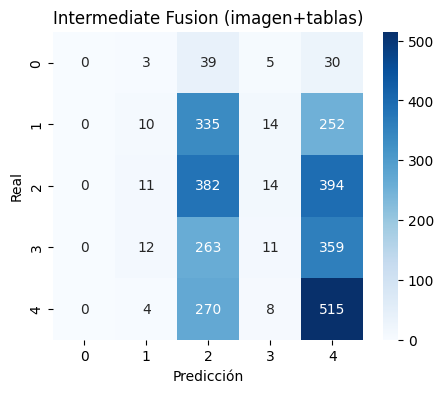

,modelo,acc,f1_macro
0,solo_imagen,0.308086,0.204253
1,solo_tabular,0.344251,0.259381
2,early_fusion,0.271238,0.098146
3,intermediate_fusion,0.313204,0.173339


In [ ]:
results = []

# Solo imagen
yt_img, yp_img = predict_ds_image(img_model, test_img_ds)
acc_i, f1_i = eval_probs(yt_img, yp_img, name="Solo imagen")
results.append({"modelo": "solo_imagen", "acc": acc_i, "f1_macro": f1_i})

# Solo tabular
yt_tab, yp_tab = predict_ds_tab(tab_model, test_tab_ds)
acc_t, f1_t = eval_probs(yt_tab, yp_tab, name="Solo tabular")
results.append({"modelo": "solo_tabular", "acc": acc_t, "f1_macro": f1_t})

# Early fusion
yt_early, yp_early = predict_ds_mm(early_model, test_mm_ds)
acc_e, f1_e = eval_probs(yt_early, yp_early, name="Early Fusion (imagen+tablas)")
results.append({"modelo": "early_fusion", "acc": acc_e, "f1_macro": f1_e})

# Intermediate fusion
yt_inter, yp_inter = predict_ds_mm(inter_model, test_mm_ds)
acc_m, f1_m = eval_probs(yt_inter, yp_inter, name="Intermediate Fusion (imagen+tablas)")
results.append({"modelo": "intermediate_fusion", "acc": acc_m, "f1_macro": f1_m})

# Late fusion: promedio simple de probabilidades imagen + tabular
# yp_late = 0.5 * yp_img + 0.5 * yp_tab
# acc_l, f1_l = eval_probs(yt_img, yp_late, name="Late Fusion (promedio imagen+tabular)")
# results.append({"modelo": "late_fusion", "acc": acc_l, "f1_macro": f1_l})

# Resumen comparativo
results_df = pd.DataFrame(results)
results_df
